In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix


from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Load processed datasets
df_train = pd.read_csv("train_data_feature_engineered.csv")
df_test = pd.read_csv("test_data_feature_engineered.csv")

In [13]:
# Check if there are any rows where Total_Traffic is 0
zero_traffic_rows_train = df_train[df_train["Total_Traffic"] == 0]
zero_traffic_rows_test = df_test[df_test["Total_Traffic"] == 0]

# Print the count of rows with Total_Traffic == 0
print("Rows with 0 Total_Traffic in train data:", len(zero_traffic_rows_train))
print("Rows with 0 Total_Traffic in test data:", len(zero_traffic_rows_test))


Rows with 0 Total_Traffic in train data: 2
Rows with 0 Total_Traffic in test data: 0


In [14]:
# Remove rows where Total_Traffic is 0
df_train = df_train[df_train["Total_Traffic"] > 0]


In [15]:
from sklearn.cluster import KMeans

# Apply K-Means clustering 
kmeans = KMeans(n_clusters=3, random_state=42)
df_train["Traffic_Class"] = kmeans.fit_predict(df_train[["Total_Traffic"]])
df_test["Traffic_Class"] = kmeans.predict(df_test[["Total_Traffic"]])


Cluster Centers:
 [[ 139848.16463909]
 [1723826.88516746]
 [ 568692.45179584]]
Cluster Summary Statistics:
                 count          mean            std        min         25%  \
Traffic_Class                                                               
0              3696.0  1.396740e+05  102232.556865      305.0    50228.75   
1               210.0  1.721080e+06  414897.283802  1146961.0  1344567.50   
2              1060.0  5.675404e+05  195612.490293   354290.0   421511.50   

                     50%         75%        max  
Traffic_Class                                    
0               116793.5   227980.75   354265.0  
1              1647068.5  2074473.25  2707064.0  
2               509747.5   641875.75  1144807.0  


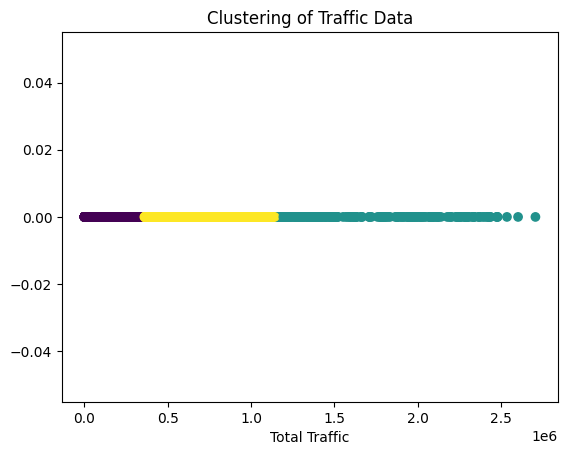

In [16]:
# View the cluster centers
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)
# Get descriptive statistics for each cluster
cluster_summary = df_train.groupby("Traffic_Class")["Total_Traffic"].describe()
print("Cluster Summary Statistics:\n", cluster_summary)


# Plot the distribution of Total_Traffic by cluster
plt.scatter(df_train["Total_Traffic"], [0] * len(df_train), c=df_train["Traffic_Class"], cmap='viridis')
plt.xlabel("Total Traffic")
plt.title("Clustering of Traffic Data")
plt.show()


From the KMeans output, we can infer:

Cluster 0 contains records with relatively moderate traffic, Cluster 1 low traffic, and Cluster 2 high traffic.

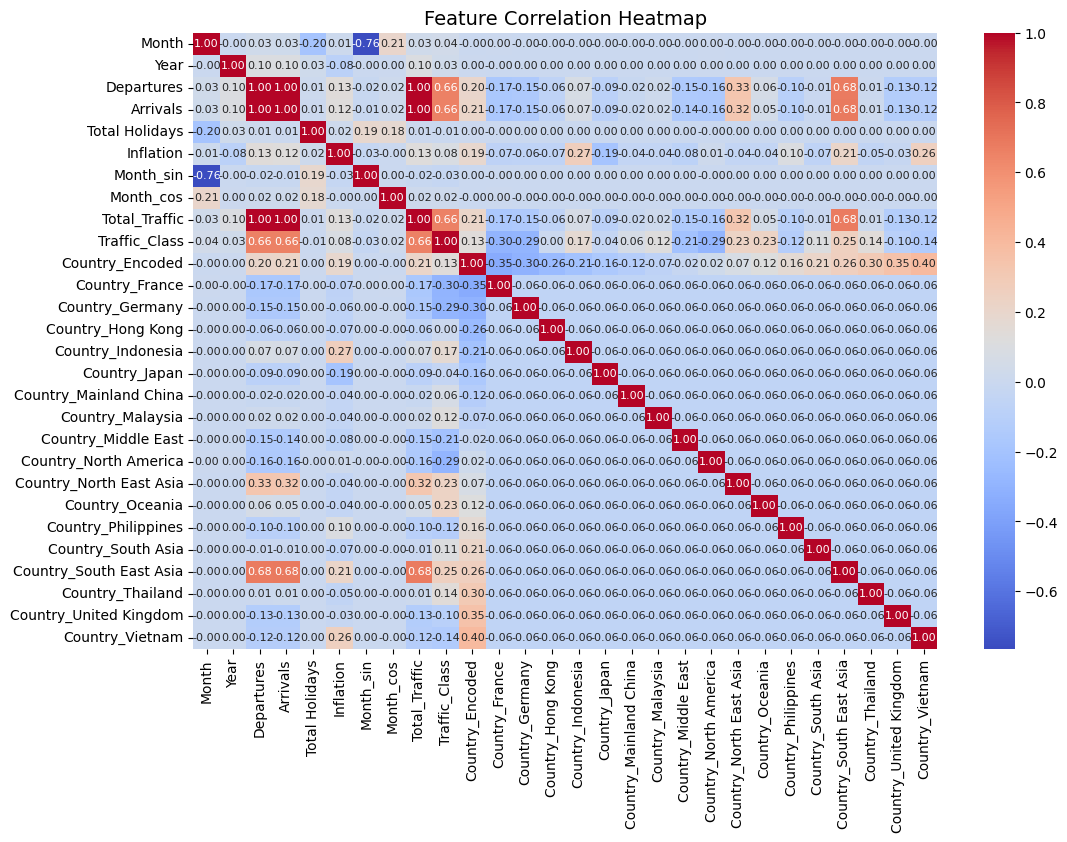

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_train["Country_Encoded"] = encoder.fit_transform(df_train["Country"])
df_train = pd.get_dummies(df_train, columns=["Country"], drop_first=True)

correlation_matrix = df_train.corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(12, 8))

# Generate heatmap with smaller annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8})

# Adjust title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Show plot
plt.show()


In [10]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_test["Country"], df_test["Traffic_Class"])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

if p < 0.05:
    print("There is a significant relationship between Country and Traffic_Class.")
else:
    print("There is no significant relationship between Country and Traffic_Class.")


Chi-Square Statistic: 788.3694215318963
P-Value: 1.0871252093057392e-143
There is a significant relationship between Country and Traffic_Class.


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
# Define target and features
X = df_train.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
# Encode categorical variables
X = pd.get_dummies(X, columns=["Country"], drop_first=True)  # One-hot encoding
y = df_train["Traffic_Class"]  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#regularization 
# Train Random Forest
clf = RandomForestClassifier(class_weight='balanced' ,random_state=42)
    # n_estimators=100,        # More trees for stability
    # max_depth=10,            # Limits how deep each tree can grow
    # min_samples_split=5,     # Minimum samples needed to split a node
    # min_samples_leaf=2,      # Minimum samples needed in a leaf node
    # max_features="sqrt",     # Reduces correlation between trees
    # random_state=42
# )

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9697986577181208


In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score


# Define target and features
X_test2 = df_test.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
y_test2 = df_test["Traffic_Class"]  # Target

# Encode categorical variables
X_test2 = pd.get_dummies(X_test2, columns=["Country"], drop_first=True)  # One-hot encoding

X_test_scaled = scaler.transform(X_test2)

# Extract true labels
y_test2 = df_test["Traffic_Class"]  # Make sure this column exists in test_data.csv

# Predict and evaluate
y_pred2 = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test2, y_pred2))

Accuracy: 0.6748329621380846


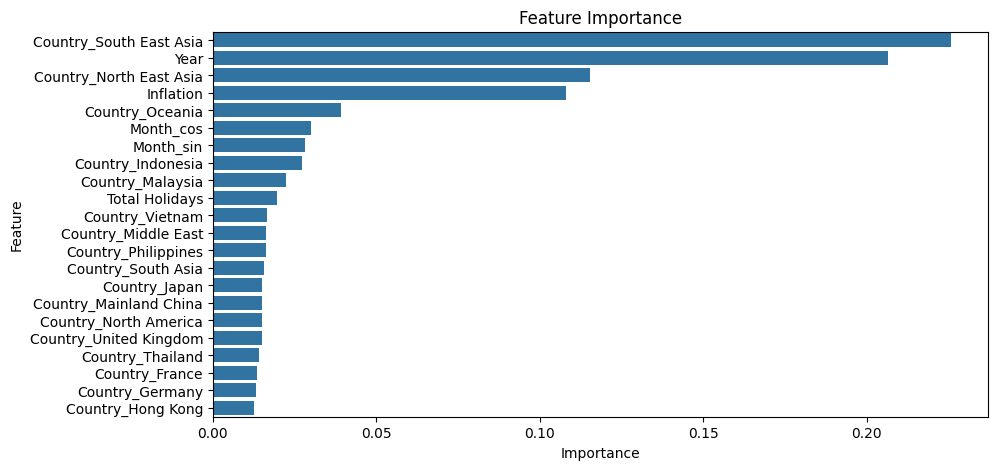

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame for visualization
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance")
plt.show()


Fine-Tuning the Hyperparameters:
n_estimators - Specifies the number of decision trees
Higher values can increase model stability and reduces variance.

max_depth - Limits how deep each decision tree can grow
Higher depth captures more complex patterns

max_features - Determines how many features are randomly selected at each split.
min_samples_split - The minimum number of samples required to split an internal node in a decision tree
Higher values prevent overfitting

min_samples_leaf - The minimum number of samples that must be present in a leaf node
Setting a higher leaf size ensures the model focuses on meaningful patterns rather than noise.

max_samples - The proportion of the dataset sampled for each tree
By lowering the values, increases tree diversity and reduce overfitting

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 75, 100],  
    "max_depth": [5, 10, 15],  
    "max_features": ["sqrt", "log2"],  
    "min_samples_split": [10, 20, 30],  
    "min_samples_leaf": [5, 10, 15],  
    "max_samples": [0.7, 0.8, 0.9]  
}

# Set up GridSearchCV with cross-validation (cv=5 for 5-fold cross-validation)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best hyperparameters
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}


In [23]:
# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use the best model found by grid search to make predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_acc:.4f}")
print(f"Test Balanced Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Train Accuracy: 0.9465
Test Accuracy: 0.8641
Train Balanced Accuracy: 0.9465
Test Balanced Accuracy: 0.8641


In [24]:
#try with randomsearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter 
param_dist = {
    "n_estimators": [50, 75, 100],  # Reduce number of trees
    "max_depth": [5, 10, 15],  # Reduce depth
    "max_features": ["sqrt", "log2"],  # Feature selection
    "min_samples_split": [10, 20, 30],  # Increase minimum split
    "min_samples_leaf": [5, 10, 15],  # Increase leaf size
    "max_samples": [0.7, 0.8, 0.9]  # Reduce sampling per tree
}


# Set up GridSearchCV with cross-validation (cv=5 for 5-fold cross-validation)
random_search =  RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

# Fit the model with grid search
random_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Train model with best hyperparameters
best_rf_random = random_search.best_estimator_


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 15}


In [25]:
# Best hyperparameters
print(f"Best Hyperparameters: {random_search.best_params_}")

# Use the best model found by grid search to make predictions
y_train_pred = best_rf_random.predict(X_train)
y_test_pred = best_rf_random.predict(X_test_scaled)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_acc:.4f}")
print(f"Test Balanced Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 15}
Train Accuracy: 0.9456
Test Accuracy: 0.8330
Train Balanced Accuracy: 0.9456
Test Balanced Accuracy: 0.8330


In [26]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation with the best model
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy') #10-fold

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Scores: [0.92241379 0.94827586 0.9137931  0.93390805 0.92528736 0.96551724
 0.91930836 0.93371758 0.93083573 0.92795389]
Mean Cross-Validation Accuracy: 0.9321


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       229
           1       0.86      1.00      0.92        43
           2       1.00      0.58      0.73       177

    accuracy                           0.83       449
   macro avg       0.88      0.86      0.84       449
weighted avg       0.87      0.83      0.82       449



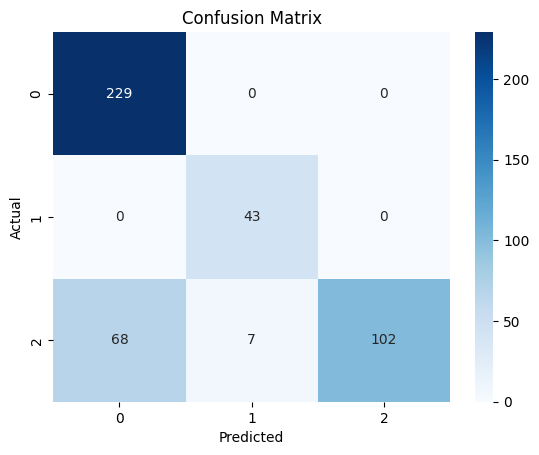

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test2, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test2, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [29]:
# Save Traffic_Class to train and test CSV files - final one

# Save the train DataFrame with the new Traffic_Class column
df_train.to_csv('train_data_with_traffic_class.csv', index=False)

# Save the test DataFrame with the new Traffic_Class column
df_test.to_csv('test_data_with_traffic_class.csv', index=False)

print("Files saved with Traffic_Class column!")

Files saved with Traffic_Class column!


To understand the model better, I implemented the use of Shapley Additive Explanations (SHAP) to help interpret the model. 
SHAP values are useful in showing how each feature contributes to the prediction of the model. 

In [24]:
import shap 
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Generate a SHAP summary plot
#shap.summary_plot(shap_values[1], X_test)

c:\Users\Vianiece\Desktop\INF2008 Machine Learning\traveltrends\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP values shape: (449, 22, 3)
X_test_scaled shape: (449, 22)


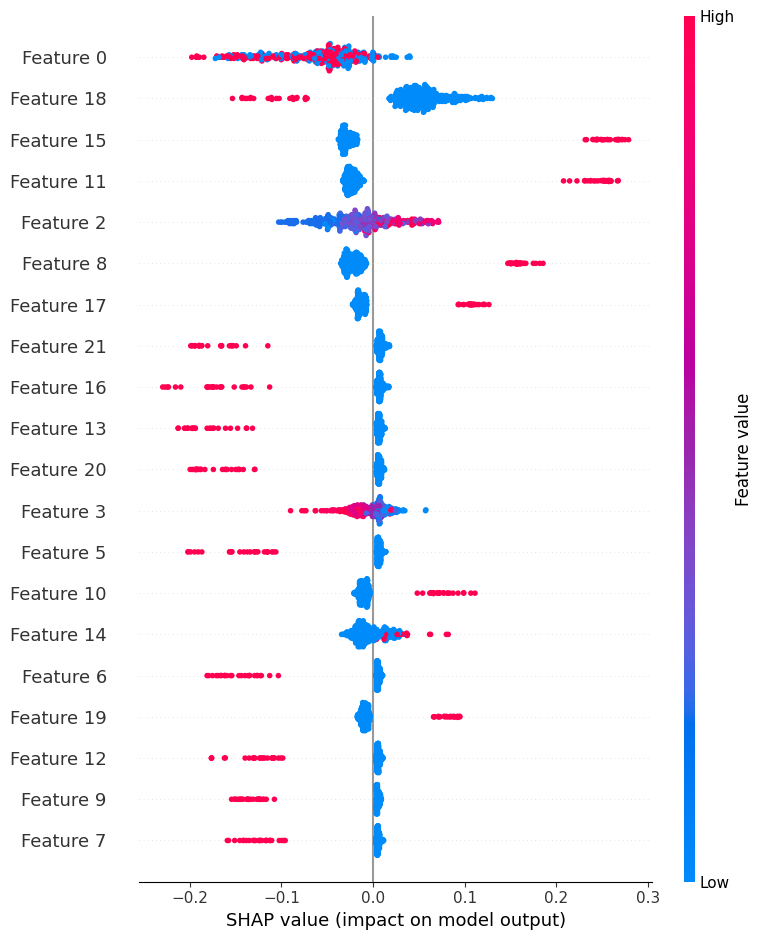

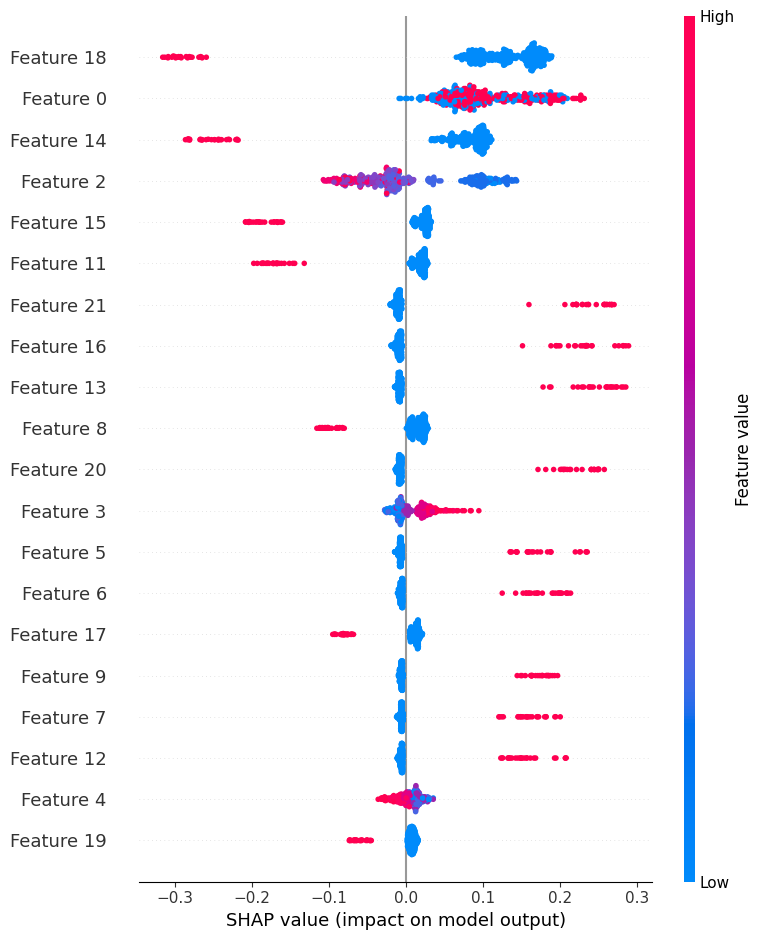

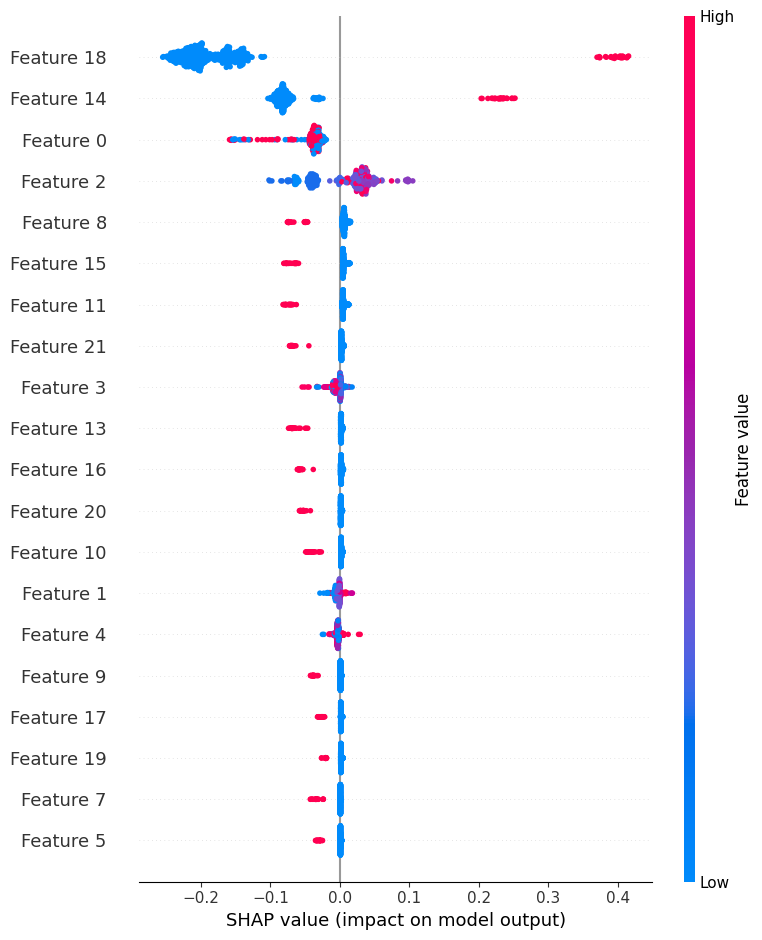

In [38]:
import shap

# SHAP values for class 0
shap.summary_plot(shap_values[:, :, 0], X_test_scaled)

# SHAP values for class 1
shap.summary_plot(shap_values[:, :, 1], X_test_scaled)

# SHAP values for class 2
shap.summary_plot(shap_values[:, :, 2], X_test_scaled)


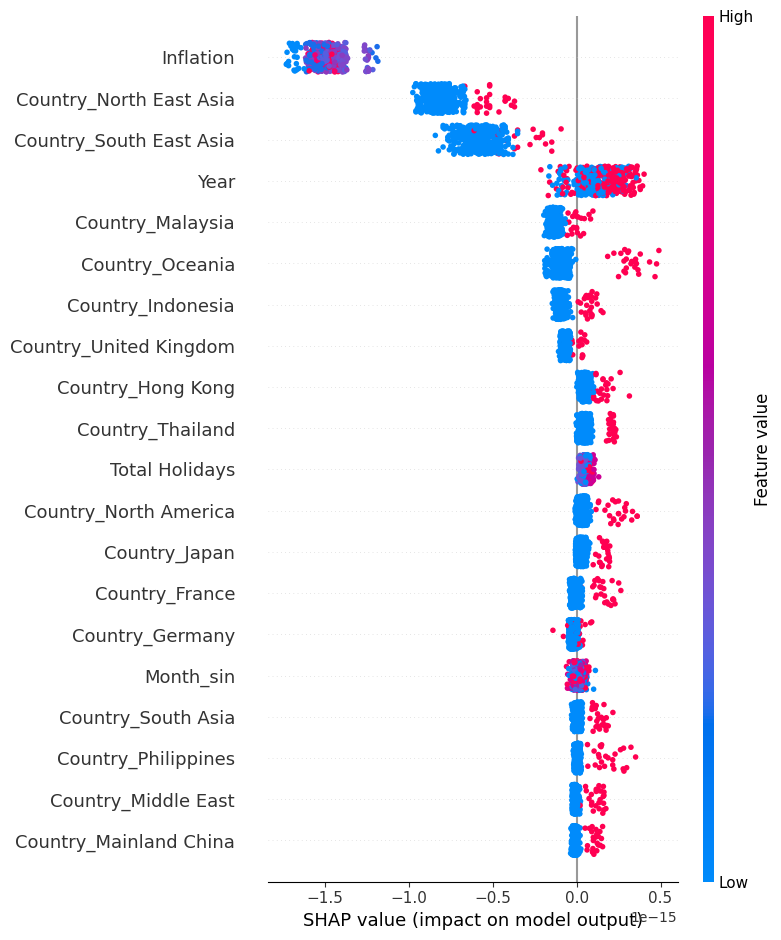

In [25]:
import pandas as pd

# Convert back to DataFrame with original feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test2.columns)

# SHAP summary plot with feature names
shap.summary_plot(shap_values.mean(axis=2), X_test_scaled_df)


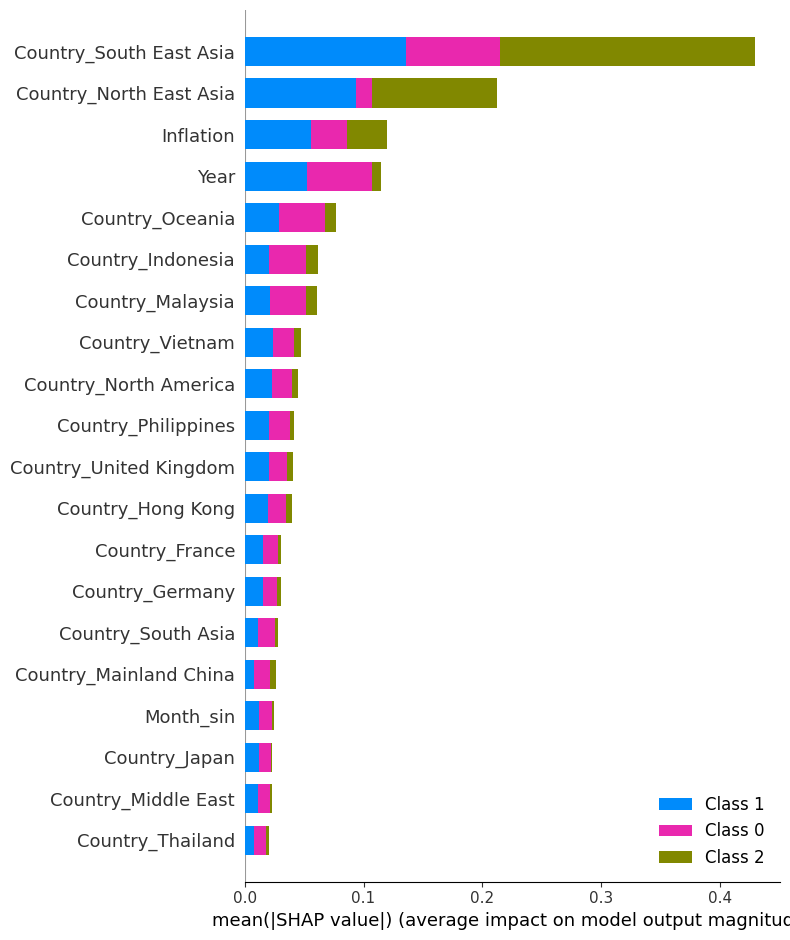

In [27]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test2.columns, plot_type="bar")


Findings:
How features affects 'traffic_class'
+ Geographical features play a huge role in the prediction. 

Countries in South East Asia and North East Asia play the biggest role in determining traffic_class.
This suggests that regional airport activity, air traffic regulations, and demand patterns strongly influence the classification.

+ Macroeconomic Factors (Inflation) Influence Traffic:

Inflation affects passenger behavior, potentially impacting airline ticket sales, operational costs, and demand.
A high inflation rate might correlate with lower air traffic due to increased travel costs.

+ Time Trends Matter:

Year influences classification, meaning that changes in global or regional airline policies, economic cycles, or COVID-19-related impacts may have shaped air traffic patterns.
Month_sin (seasonality effect) has a minor impact but still contributes to seasonal fluctuations in air travel.

Conclusion & Business Insights:
- Geographic region is the strongest factor in traffic classification

Policymakers and airline companies in these regions can use this insight to optimize flight routes and airport operations.

- Macroeconomic conditions impact traffic patterns

Inflation plays a role in classification, suggesting that economic downturns or price fluctuations influence flight demand.
Airlines can adjust pricing strategies based on economic trends.

- Time-Based Trends Indicate Evolving Traffic Patterns

Year affects classification, showing that traffic patterns change over time due to external events, regulatory changes, or technology advancements.
This insight is valuable for predicting future trends in air travel.

Future Actionable Steps for Stakeholders
✔ Airlines should optimize their pricing models based on regional economic conditions.
✔ Airport authorities should monitor geographic traffic trends and allocate resources accordingly.
✔ Future models should incorporate more dynamic time-based variables to improve predictions.

